### **籌碼集中度**
策略出處：台灣股票市場屬於淺碟市場，所謂淺碟代表的是沒有深度，容易受到外部的震盪，而在股票市場則代表，容易受到外部力量干擾，而有明顯的漲跌幅情況，像是受到新聞的影響、或是投資大戶對單一股票大量的買入，都會明顯影響股價表現，因此根據這種籌碼的行為模式，買入大量籌碼集中之股票可能會有賺取超額報酬的機會存在。

溫馨提示：此策略載入資料量較大，電腦記憶體若為16G者請斟酌回測期間，以免記憶體不足導致程式崩潰。

* 指標計算：

        籌碼集中度 = (買方前15大買進量 - 賣方前15大賣出量) / 總成交量

* 交易邏輯：

        買入近N天籌碼集中度最高的M家公司

###  Tejapi、Zipline、Pyfolio套件引入

In [1]:
import tejapi
import os
os.environ['TEJAPI_KEY'] = 'your key'
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor, AverageDollarVolume, SimpleMovingAverage, Returns
from zipline.master import get_prices, getToolData, tejquant, run_pipeline
from TejToolAPI.TejToolAPI import get_history_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import defaultdict
from time import time
from tqdm import trange

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         date_rules,
                         time_rules,
                         record,
                         schedule_function,
                         commission,
                         slippage,
                         set_slippage,
                         set_commission,
                         set_cancel_policy,
                         get_open_orders,
                         get_datetime,
                         cancel_order,
                         order_target,
                         order_target_value,
                         order_target_percent,
                         set_benchmark,
                         symbol,
                         )
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet, tejquant
from zipline.pipeline.domain import TW_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader
from zipline.finance.execution import StopOrder, LimitOrder
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

### 資料載入－Tejapi、TejToolAPI

* 擷取至2023/08/07所有上下市櫃公司股票代碼

In [4]:
code = tejapi.get('TWN/ANPRCSTD', mdate={'lt':'2023-08-07'}, chinese_column_name=True, paginate=True)

all_code = code[(code['證券種類名稱'].isin(['普通股'])) & (code['上市別'].isin(['TSE', 'OTC', 'DIST']))]['證券碼'].to_list() 

* 載入2020年1月至2023年8月上述公司每日的主要券商進出買進、賣出股數

In [5]:
chip = pd.DataFrame()

data_range = pd.date_range('2020-01-01', '2023-08-07', freq='MS').date

for i in trange(len(data_range)-1):

    chip = pd.concat([chip, tejapi.fastget('TWN/AMTOP1',  
                                        paginate=True,
                                        coid=all_code,
                                        mdate = {'gt':data_range[i] - pd.Timedelta(days=1), 'lt':data_range[i+1] + pd.Timedelta(days=1)},
                                        opts={'columns':['coid', 'mdate', 'key3', 'buy', 'sell']})])

chip = chip.drop_duplicates(subset=['coid', 'mdate', 'key3'])
chip = chip.dropna()

100%|██████████| 43/43 [08:37<00:00, 12.02s/it]


* Ingest上述公司2020-01-01至2023-08-07的股價資料與大盤報酬指數收盤價進bundle

In [6]:
# os.environ['TEJAPI_KEY'] = "4WBk8YaUj7JOl6fgALRDHYaPF9F5pl"
# os.environ['ticker'] = ' '.join(all_code) + ' IR0001'
# os.environ['mdate'] = '20200101 20230807'

# !zipline ingest -b tquant

* 使用get_history_data載入上述公司同期間之市值

In [7]:
mv = get_history_data(ticker=all_code, columns=['Market_Cap_Dollars'], start='2020-01-01', end='2023-08-07')

* 整合每檔個股每天券商成交股數前15筆最大筆的資料

In [8]:
chip_top = chip.groupby(['coid', 'mdate']).agg(top_buy=('buy', lambda x: x.nlargest(15).sum()), top_sell=('sell', lambda x: x.nlargest(15).sum()))

chip_top = chip_top.join(mv.set_index(['coid', 'mdate']))

chip_top = chip_top.reset_index()

* 將載入後的資料轉換成Zipline所需格式

In [9]:
def Custom_loader(df, bundle):

    df['coid'] = df['coid'].astype(str)
    
    #收集coid, mdate以外的欄位作為之後字典的key
    column = df.columns[~df.columns.isin(['coid', 'mdate'])].tolist()

    #抓取目前bundle中所有的symbols
    sids = bundle.asset_finder.equities_sids
    assets = bundle.asset_finder.retrieve_all(sids)
    symbols = [i.symbol for i in assets] 

    #找出df內有在bundle股票代碼中的個股
    target_symbols = df[df['coid'].isin(symbols)]['coid'].unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(target_symbols, as_of_date=None)
    assets_map = {i.symbol: i for i in assets}

    baseline_data = {}

    #建立後續用於CustomDataset的字典
    df1 = df.set_index(['coid', 'mdate'])
    for i in column:
        target = df1.unstack('coid')[i][target_symbols]
        target.columns = target.columns.map(assets_map)
        target = target.tz_localize('UTC').tz_convert('UTC')
        baseline_data.update({i: target})

    return baseline_data

In [10]:
bundle = bundles.load('tquant')

baseline_data = Custom_loader(chip_top, bundle)

###  Pipeline－進出場指標計算

* 買賣方前十五大股數與放入Pipeline以計算籌碼集中度指標

In [11]:
class CustomDataset(DataSet):
    chip_buy = Column(dtype=float)
    chip_sell = Column(dtype=float)
    mv = Column(dtype=float)

    domain = TW_EQUITIES     
    
transform_data = {CustomDataset.chip_buy: DataFrameLoader(CustomDataset.chip_buy, baseline_data['top_buy']),
                  CustomDataset.chip_sell: DataFrameLoader(CustomDataset.chip_sell, baseline_data['top_sell']),
                  CustomDataset.mv: DataFrameLoader(CustomDataset.mv, baseline_data['Market_Cap_Dollars'])}

transform_data

{CustomDataset<TW>.chip_buy::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x22da447a9a0>,
 CustomDataset<TW>.chip_sell::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x22da447a580>,
 CustomDataset<TW>.mv::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x22d70b082b0>}

* 選取近月報酬率最高前20%之個股&長短均籌碼面指標需大於0

In [33]:
def make_pipeline(sma, lma):

    buy_sma = SimpleMovingAverage(inputs=[CustomDataset.chip_buy], window_length=sma)
    buy_lma = SimpleMovingAverage(inputs=[CustomDataset.chip_buy], window_length=lma)

    sell_sma = SimpleMovingAverage(inputs=[CustomDataset.chip_sell], window_length=sma)
    sell_lma = SimpleMovingAverage(inputs=[CustomDataset.chip_sell], window_length=lma)

    vol_sma = SimpleMovingAverage(inputs=[TWEquityPricing.volume], window_length=sma)
    vol_lma = SimpleMovingAverage(inputs=[TWEquityPricing.volume], window_length=lma)

    chip_sma = (buy_sma - sell_sma) / vol_sma * 100
    chip_lma = (buy_lma - sell_lma) / vol_lma * 100

    month_returns = Returns(inputs=[TWEquityPricing.close], window_length=20)

    mv = CustomDataset.mv.latest
    vol = TWEquityPricing.volume.latest

    pipe = Pipeline(
        columns={
            'chip_sma': chip_sma,
            'chip_lma': chip_lma,
            'mv': mv,
            'vol': vol
            },
            screen = month_returns.rank().percentile_between(80, 100) & (chip_sma > 0) & (chip_lma > 0)
    )
    return pipe

* 籌碼集中度相關指標計算

In [34]:
start_dt = pd.Timestamp('2020-01-01', tz='utc')
end_dt = pd.Timestamp('2023-08-01', tz='utc')

from zipline.data import bundles
bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

from zipline.pipeline.loaders import EquityPricingLoader

pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader, bundle.adjustment_reader)

def choose_loader(column):
    if column in TWEquityPricing.columns:
        return pricing_loader
    return transform_data[column]

from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(get_loader=choose_loader,
                              asset_finder=bundle.asset_finder,
                              )
pipe = make_pipeline(60, 120)
data = engine.run_pipeline(pipe, start_dt, end_dt)
data

chip_sma  chip_lma            mv        vol
2020-02-10 00:00:00+00:00 Equity(18 [1227])    0.016247  0.032495  6.478834e+10  1157000.0
                          Equity(19 [1229])    0.015520  0.031040  4.153822e+10  2456000.0
                          Equity(24 [1235])    0.007061  0.014123  2.201758e+09    13000.0
                          Equity(49 [1333])    0.004304  0.008608  1.646790e+08   103000.0
                          Equity(54 [1409])    0.011288  0.022577  1.990643e+10  5072000.0
...                                                 ...       ...           ...        ...
2023-08-01 00:00:00+00:00 Equity(1594 [8234])  0.001298  0.001762  8.996126e+09  6867000.0
                          Equity(1619 [8410])  0.001369  0.001434  1.888003e+09   155000.0
                          Equity(1631 [8438])  0.000592  0.000032  1.979387e+09   410000.0
                          Equity(1667 [8936])  0.000078  0.000548  9.129276e+09  3236000.0
                          Equity(1693 [9929])  0.011030  0.007446  1.088760e+09   181000.0

[118556 rows x 4 columns]

### Zipline－策略回測

* 策略參數：短均60天、長均120天

* 設定固定滑價成本和交易手續費各為0.2%
  
* 月初進場邏輯：每天買進股票池中符合條件之個股，使用短均籌碼面指標進行加權平均部位配置

* 月底出場邏輯：投組內個股全數出清

In [35]:
def initialize(context):

    set_slippage(slippage.FixedSlippage(spread=0.002))
    set_commission(commission.PerDollar(cost=0.002))

    context.last_month = 1e6
    
    schedule_function(rebalance_start, 
                      date_rules.month_start(),  
                      time_rules.market_open())
    
    schedule_function(rebalance_end, 
                      date_rules.month_end(),  
                      time_rules.market_open())


    pipeline = make_pipeline(60, 120)
    attach_pipeline(pipeline, 'make_pipeline')

def output_progress(context):

    today = get_datetime().date()
    
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    log.info(f"【{today}】投組報酬率：{perf_pct*100:.2f}%")
    
    context.last_month = context.portfolio.portfolio_value


def before_trading_start(context, data):

    context.trades = pipeline_output('make_pipeline').dropna(axis=0)


def rebalance_start(context, data):
    
    target = context.trades.copy()

    target['positions'] = target['chip_sma'] / sum(target['chip_sma'])

    for stock, chip in zip(target.index, target.positions):

        order_target_percent(stock, chip) 

def rebalance_end(context, data):

    output_progress(context)

    for stock in context.portfolio.positions.keys():
        order_target_percent(stock, 0)


    
import time
from collections import defaultdict
from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return,
                                          )


def portfolio_plot(context, results):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod()*1000000
    results[['portfolio_value', 'benchmark_cum']].plot(ax=ax1, label='Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc='upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.show()

* 回測週期：2020-01-01至2023-08-01

* 投組資金：1,000,000

* 基準指數：台股加權報酬指數(Y9997)

[2023-08-17 05:05:46.037898] INFO: Algorithm: 【2020-01-31】投組報酬率：0.00%
[2023-08-17 05:05:46.078898] INFO: Algorithm: 【2020-02-27】投組報酬率：0.00%
[2023-08-17 05:05:47.969903] INFO: Performance: Equity(1178 [5904]), cash_dividend amount: 17.1, pay_date: 2020-06-12, div_owed: 51.300000000000004
[2023-08-17 05:05:48.048902] INFO: Algorithm: 【2020-03-31】投組報酬率：-18.09%
[2023-08-17 05:05:48.885824] INFO: Performance: Equity(168 [1712]), cash_dividend amount: 1.3, pay_date: 2020-05-08, div_owed: 15.600000000000001
[2023-08-17 05:05:48.968825] INFO: Performance: Equity(115 [1524]), cash_dividend amount: 0.39999999999999997, pay_date: 2020-05-13, div_owed: 17.2
[2023-08-17 05:05:49.747826] INFO: Performance: Equity(1576 [8112]), cash_dividend amount: 2.6999999999999997, pay_date: 2020-05-22, div_owed: 132.29999999999998
[2023-08-17 05:05:50.210827] INFO: Algorithm: 【2020-04-30】投組報酬率：6.25%
[2023-08-17 05:05:52.247831] INFO: Algorithm: 【2020-05-29】投組報酬率：2.05%
[2023-08-17 05:05:53.115838] INFO: Performan

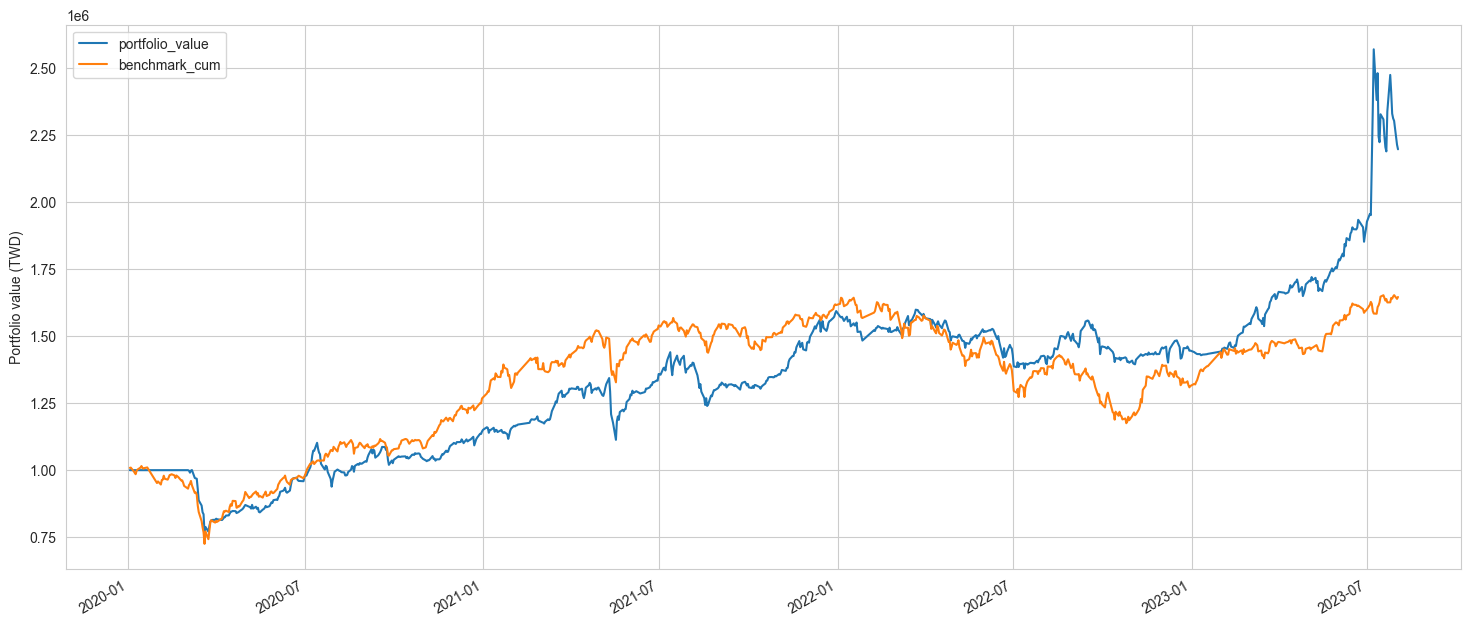

In [36]:
start_dt = pd.Timestamp('2020-01-01', tz='utc')
end_dt = pd.Timestamp('2023-08-01', tz='utc')

Bindex=get_Benchmark_Return(start=start_dt, end=end_dt, symbol='IR0001').sort_index(ascending=True).tz_convert('utc')

results = run_algorithm(start=start_dt,  
                       end=end_dt,
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       benchmark_returns=Bindex,
                       data_frequency='daily',
                       bundle='tquant',
                       custom_loader=transform_data,
                       analyze=portfolio_plot) 

### Pyfolio－投組績效分析

In [37]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline, print_table
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
results.benchmark_return.index = results.benchmark_return.index.tz_localize(None).tz_localize('UTC')

In [38]:
from pyfolio.plotting import show_perf_stats
show_perf_stats(returns=returns,
                factor_returns=results.benchmark_return,
                positions=positions,
                transactions=transactions,
                live_start_date='2022-01-01',
                )

Start date,2020-01-02
End date,2023-08-01
Total months,41
,Backtest
Annual return,25.586%
Cumulative returns,119.577%
Annual volatility,22.25%
Sharpe ratio,1.14
Calmar ratio,1.10
Stability,0.84
Max drawdown,-23.335%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.34,2020-03-06,2020-03-19,2020-07-06,87
1,17.14,2021-05-10,2021-05-17,2021-06-30,38
2,14.83,2020-07-13,2020-07-28,2020-12-04,105
3,14.81,2023-07-07,2023-07-20,NaT,NaN
4,13.93,2021-07-12,2021-08-19,2021-11-17,93


Stress Events,mean,min,max
New Normal,0.10%,-9.54%,9.65%


Top 10 long positions of all time,max
sid,
3018,99.32%
4523,23.87%
3523,19.56%
6198,16.93%
6103,13.59%
4304,12.23%
2064,12.14%
2718,11.51%
2801,11.40%


Top 10 short positions of all time,max
sid,
3073,-9.82%
2424,-1.07%
5348,-0.80%
5455,-0.39%


Top 10 positions of all time,max
sid,
3018,99.32%
4523,23.87%
3523,19.56%
6198,16.93%
6103,13.59%
4304,12.23%
2064,12.14%
2718,11.51%
2801,11.40%


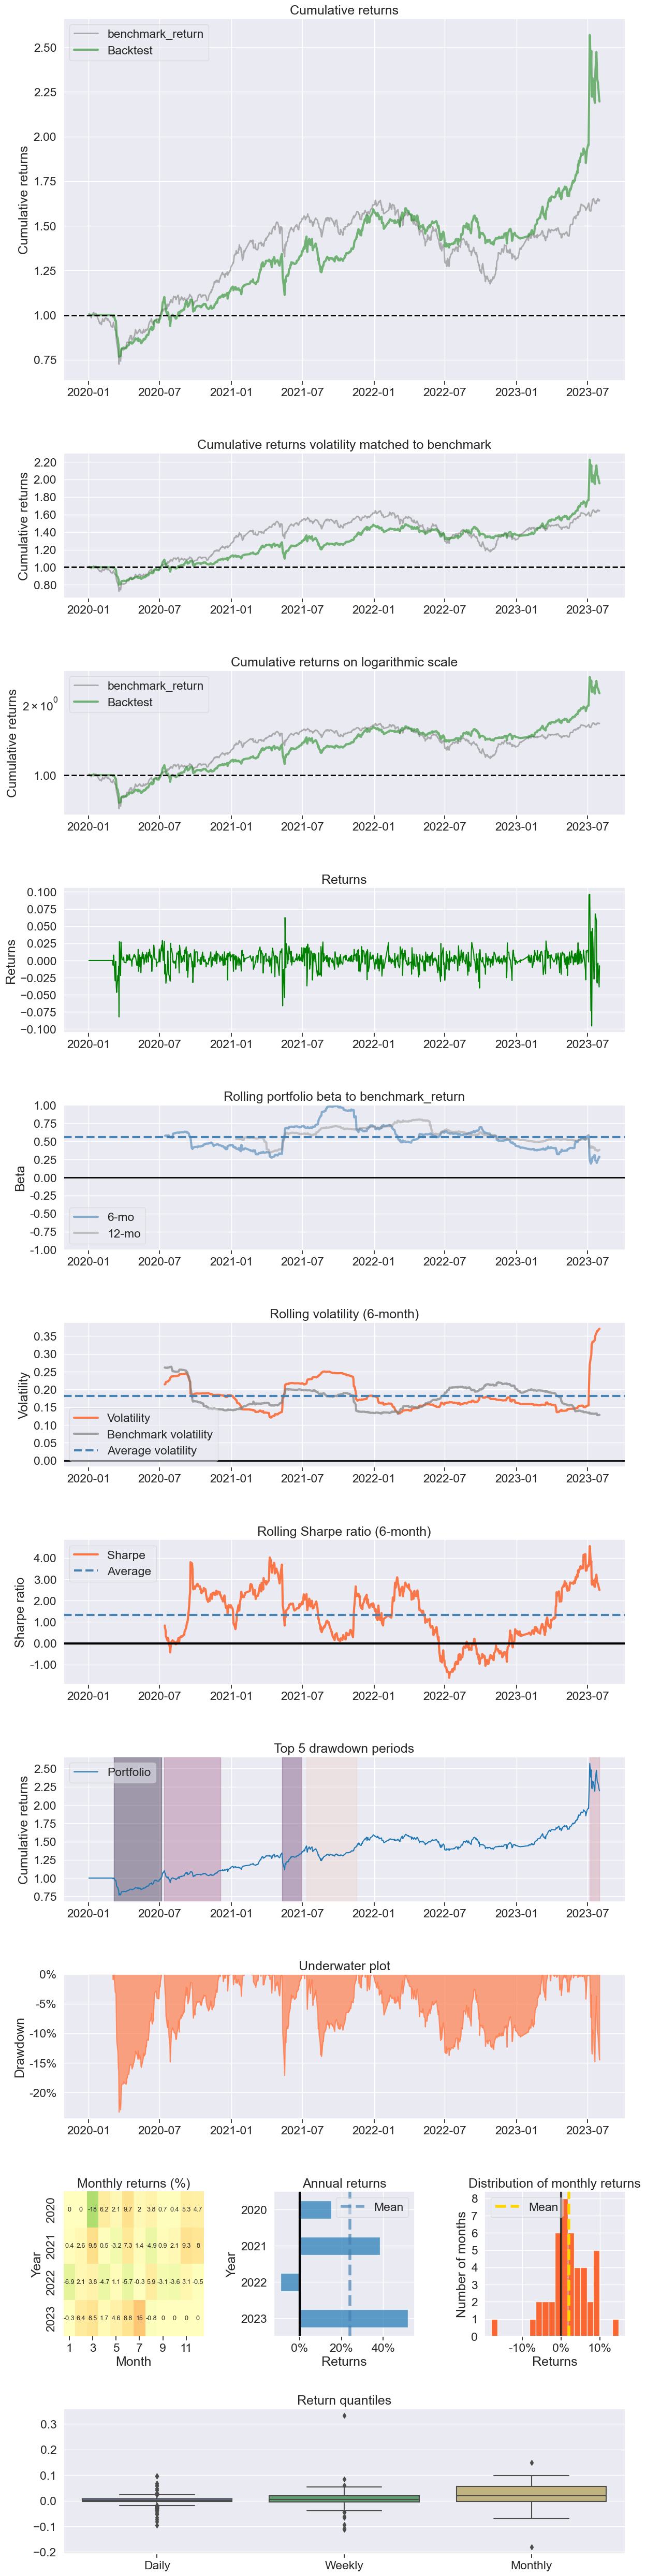

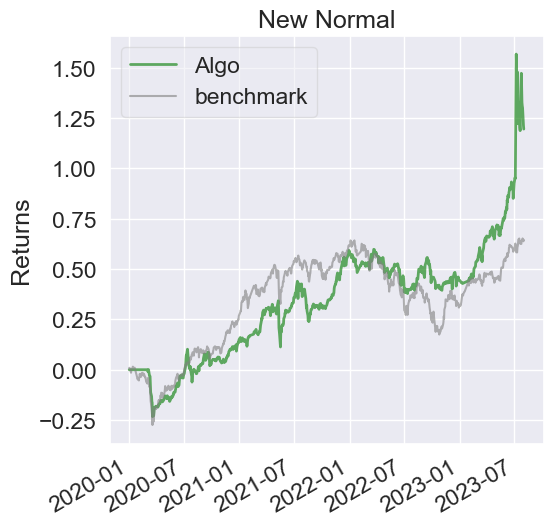

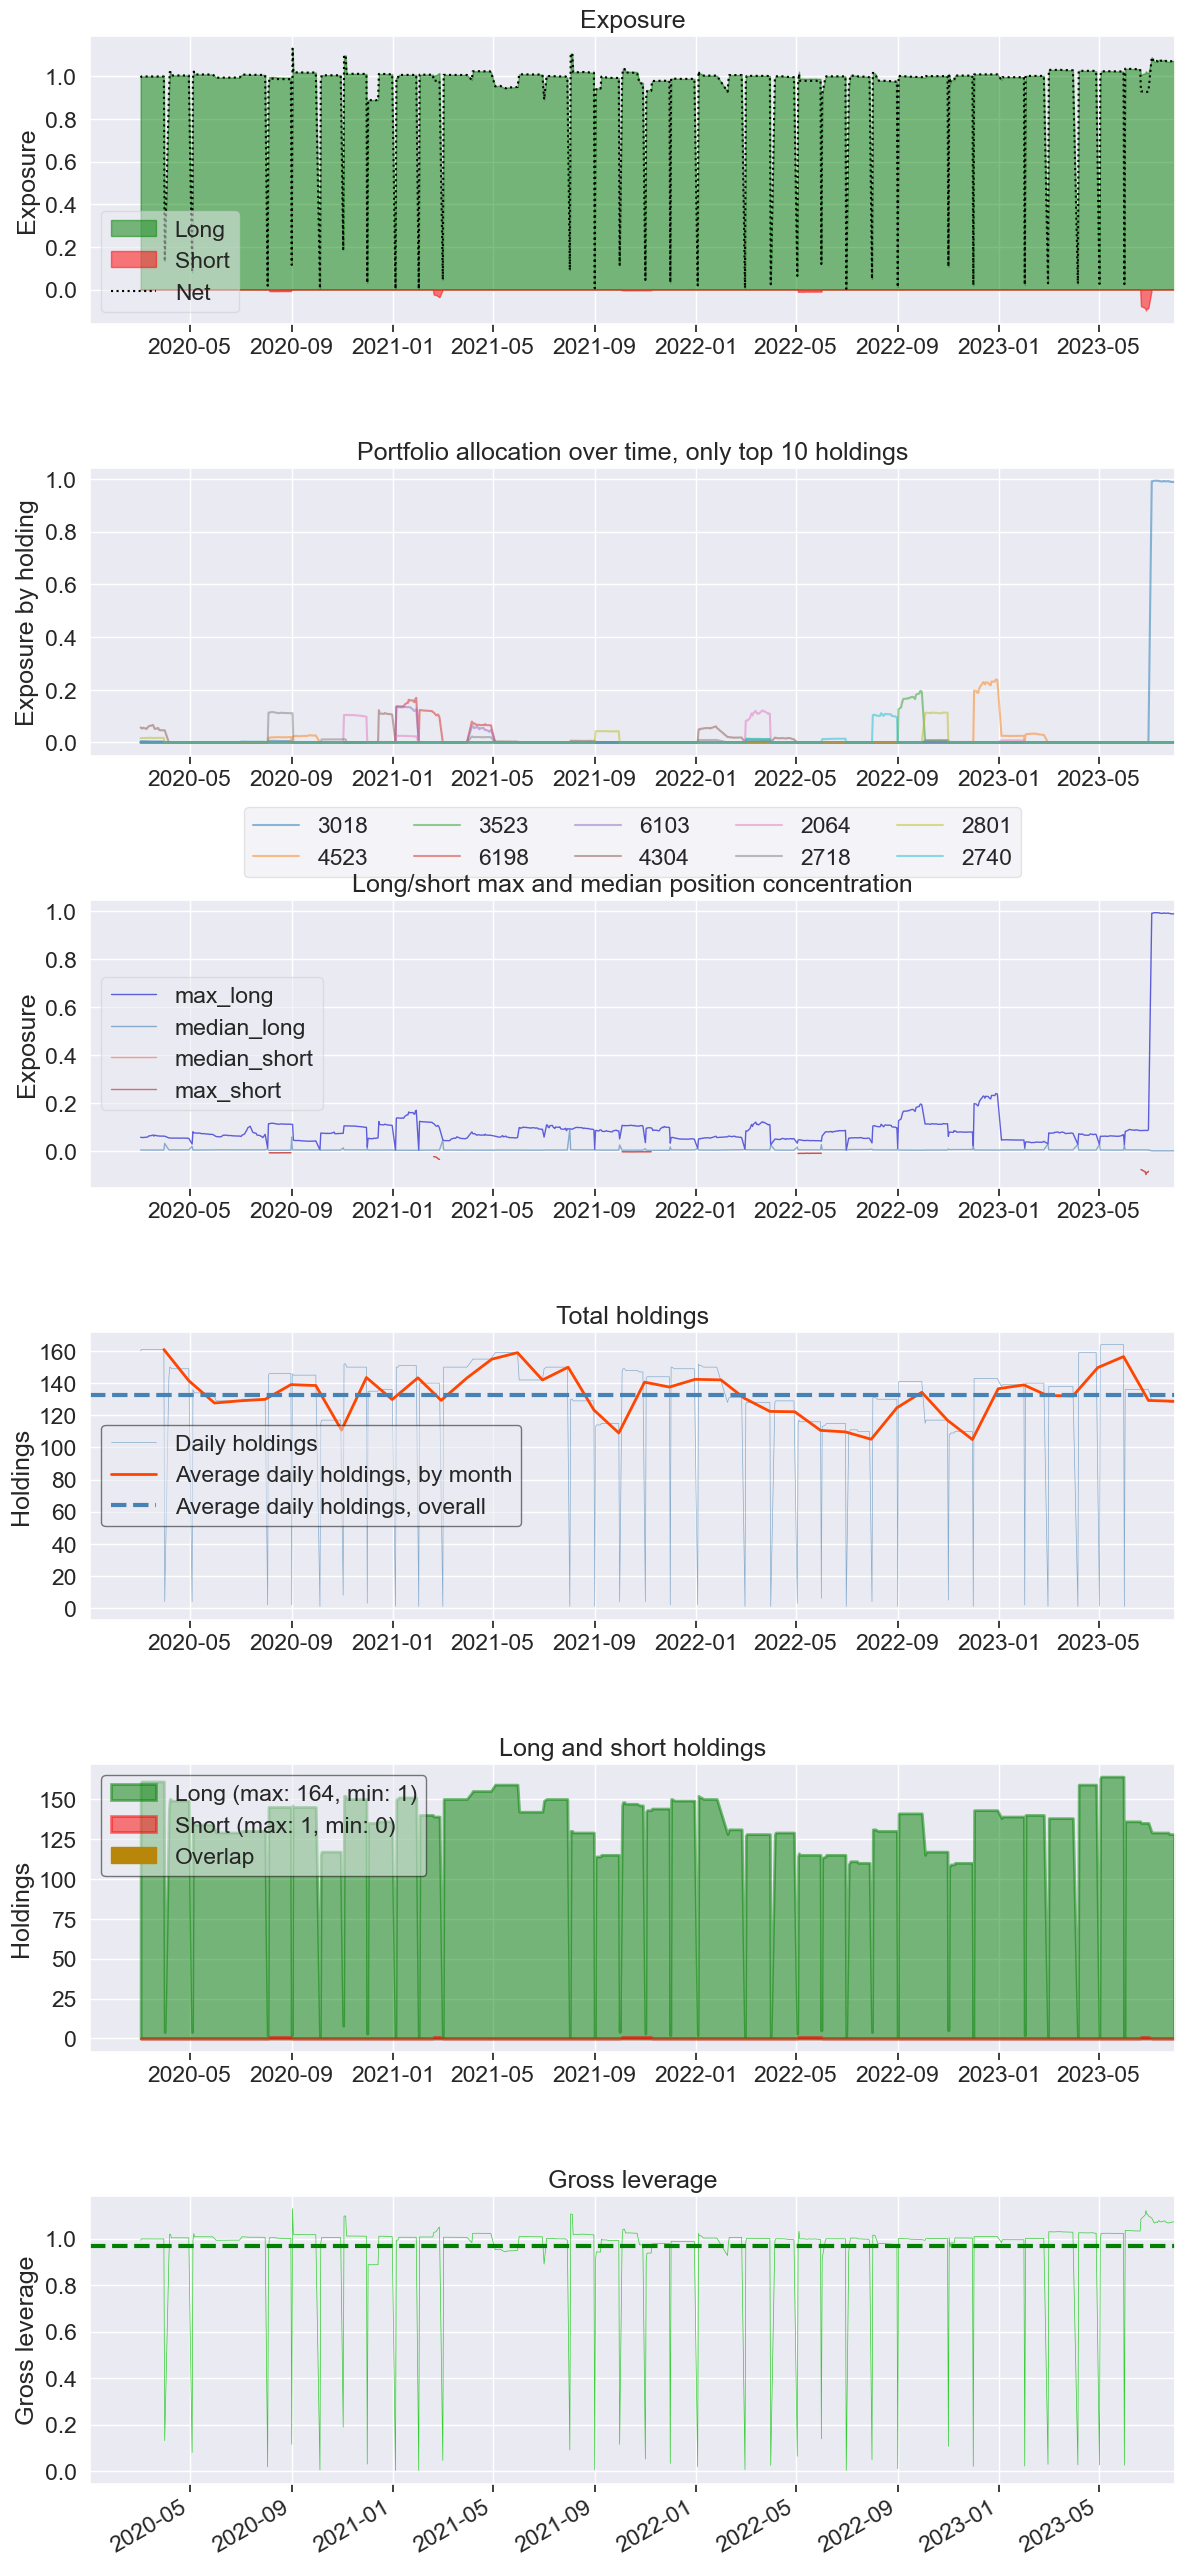

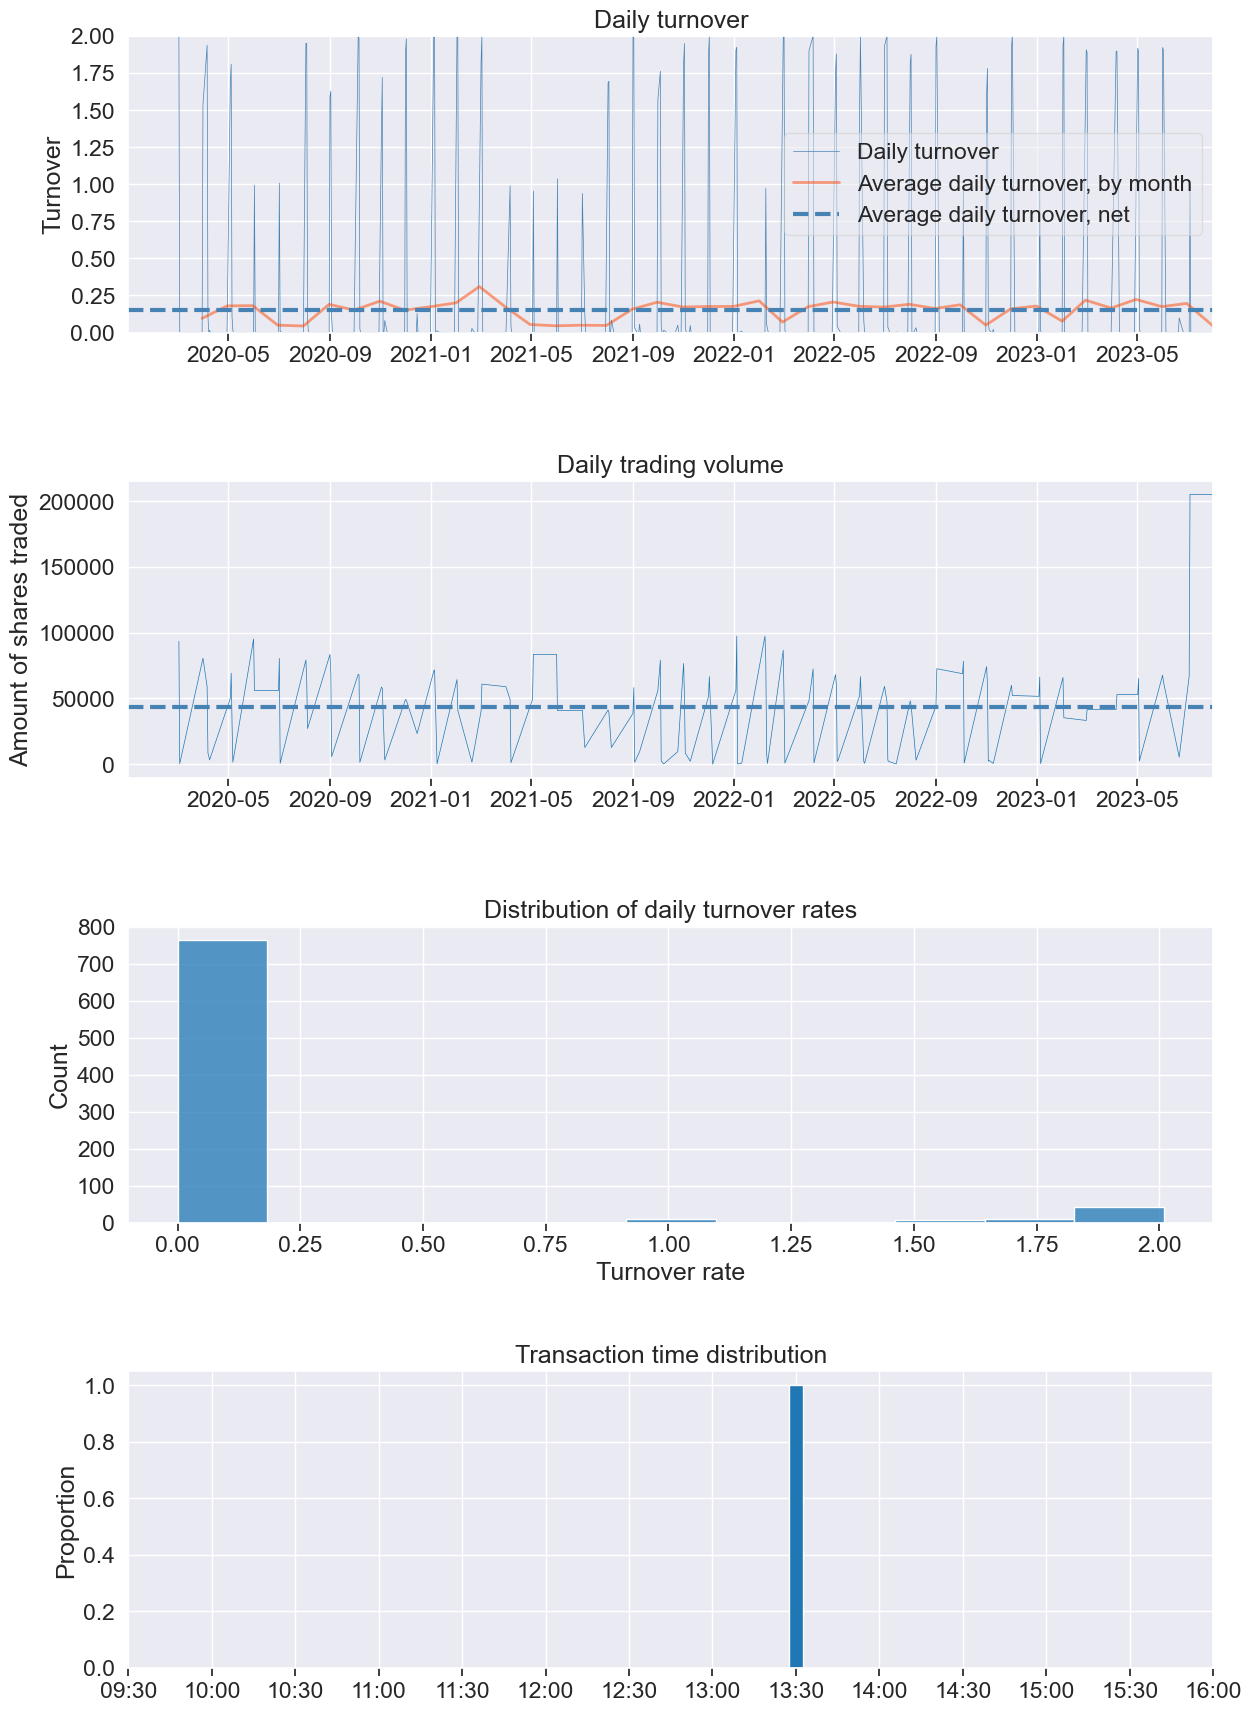

In [39]:
pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=results.benchmark_return)